# Learning Objectives of the LSTM tutorial:
* Build a simple LSTM 
* Become familiar with PyTorch
* Train models using GPU
* Use cloud hosted data (via AWS S3 -  streamflow-app-data bucket)


In [1]:
#basic packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

#modeling packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#Modeling scripts from scripts folder
from scripts.dataprocessing import readdata, create_tensors
from scripts.Simple_LSTM import Simple_LSTM, train_LSTM
from scripts.evaluation import plot, model_eval

#See if you system is using GPU (cuda) or cpu. We want to run on cpu if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


## Making a real model!
This tutorial will use USGS NWIS 10163000 in Provo, UT to demonstrate the development of a real world modeling pipeline.
We will:
* load the daily streamflow from the CIROH AWS S3 streamflow-app-data bucket in .parquet format
* process it for use in the LSTM
* use a prebuilt LSTM from [Simple_LSTM.py](/scripts/Simple_LSTM.py) to train, test, and evaluate the model

![site](Images/USGSsite.JPG)

In [2]:
#read parquet file from AWS s3 - put in credentials or updated script to not need them
#filepath = 'RJ/data/exampledata.parquet'
filepath = 'RJ/data/USGS-10163000_1980_2020.parquet'
df = readdata(filepath)
#view data
print(df.head())
#find out data types - we often need to convert the datetime to a datetime type
df.dtypes

     Datetime  USGS_flow    variable   USGS_ID measurement_unit  \
0  1984-05-15  1094.1177  streamflow  10163000            ft3/s   
1  1984-05-16   735.0417  streamflow  10163000            ft3/s   
2  1984-05-17   601.0833  streamflow  10163000            ft3/s   
3  1984-05-18   972.6250  streamflow  10163000            ft3/s   
4  1984-05-19   988.7083  streamflow  10163000            ft3/s   

      qualifiers  series  
0  ['A', '[91]']       0  
1  ['A', '[91]']       0  
2  ['A', '[91]']       0  
3  ['A', '[91]']       0  
4  ['A', '[91]']       0  


Datetime             object
USGS_flow           float64
variable             object
USGS_ID               int64
measurement_unit     object
qualifiers           object
series                int64
dtype: object

In [3]:
## #changes date as str to datetime object
df['Datetime'] = df['Datetime'].astype('datetime64[ns]')
#set index to datetime
df.set_index('Datetime', inplace = True)
#select streamflow
cols =['USGS_flow']
df = df[cols]
#remove NaN values
df.dropna(inplace = True)

df.head()

,USGS_flow
Datetime,
1984-05-15,1094.1177
1984-05-16,735.0417
1984-05-17,601.0833
1984-05-18,972.6250
1984-05-19,988.7083


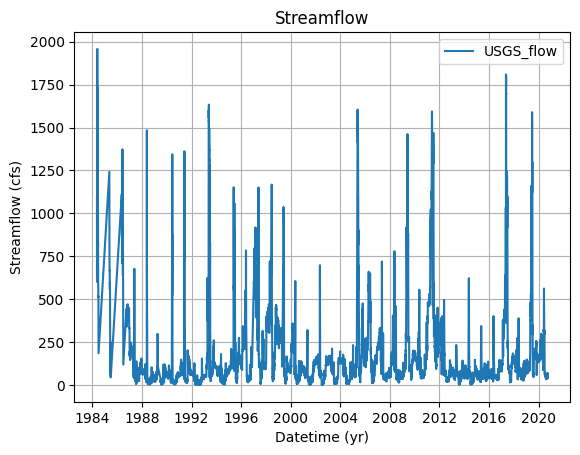

In [4]:
#plot the data
plot(df)

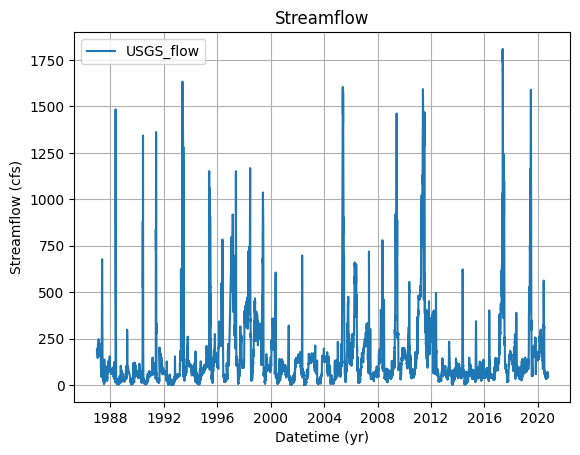

In [5]:
# The NaNs lead to missing values pre 1987, lets remove them to improve model training
df = df.loc['1987-1-1':]
#plot the data
plot(df)

In [6]:
#split data into train/test - note, for LSTM there is not need to randomize the split
timeseries = df[["USGS_flow"]].values.astype('float32') #conver the df into an array

trainsize = int(len(timeseries)*0.67) # 67% of data for training
testsize = len(timeseries)-trainsize # remaining (~33%) data for testing

train, test = timeseries[:trainsize], timeseries[-testsize:]


We typically perform simple time series prediction on a moving window (w), given data from t -w to t, with w governing how much data the model can look back on (i.e., look back period).
On a long timeseries, the developer can create multiple overlapping windows, and it is convienant to create a function to generate a dataset of a fixed window from the time series.
Since we are using PyTorch, we need to convert the dataset into tensors.

The design of the create_tensors() function is to apply windows on the time series in order to predict at timestep t+1, converting the time series into a a tensor of dimensions (window sample, time steps, features). 
A time series of n timesteps can produce approximately n windows (e.g., a window can start at any time step given the window does not exceed the boundaries of the time series). 
Within the window are multiple consecutive time steps of values, and in each time step there can be mutliple features (see [Feature_LSTM](Feature_LSTM.ipynb)).

Data processing steps must produce the features and target into the same shape. 
Example, for a window of 3 timesteps, the features are the time series from t to t+2 and the targets are from t+1 to t+3. 
We are looking to predict for t+3 but the information in t+1 and t+2 is useful for training.
From our create_tensors() function, the input time series is a 2D array and the output will be a 3D tensor.
We call the window the lookback and its setting determines how many previous time steps the model can look back to inform a prediction.
The **lookback** value is a very important value for an LSTM. 
Lets explore.

In [7]:
#set lookback
lookback = 4 #

#create testing and training tensors
X_train, y_train =  create_tensors(train, lookback = lookback)
X_test, y_test =  create_tensors(test, lookback = lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([7897, 4, 1]) torch.Size([7897, 4, 1])
torch.Size([3889, 4, 1]) torch.Size([3889, 4, 1])


# Build the LSTM
![PyTorchLSTM](Images/PytorchLSTM.JPG)

For more detailed information, please visit the [Pytorch LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

## Model Set up
We can now build the LSTM model to predict the time series using the Simple_LSTM() class from [Simple_LSTM.py](/scripts/Simple_LSTM.py).

The torch.nn call uses nn.LSTM() that accepts inputsize, hidden_size, num_layers, and batchfirst as inputs, generating a tuple as an output. 
The first element of the tuple is the generate hidden state, one for each time step of the input.
The second element is the LSTM cell  memory adn hidden states which we will not use.

We create an LSTM layer by setting the batchfirst variable to True, which makes use of the input tensors of dimensions (window sample, time steps, features).
The model creates a batch by sampling the first dimension.

The last function in the LSTM is for processing the fully connected LSTM output into a single regression result (e.g., self.linear = nn.Linear()). 
The output of the model will form as an input for the next time step.

We will select MSE as the loss function because we are performing a regression task, which will seek to minimize through the applicaiton of the Adam optimizer.
Below, we load the Simple_LSTM() class and combine with the PyTorch tensors using torch.utils.data.TensorDataset() and batch training provided by DataLoader.
A DataLoader automatically creates minibatches of the dataset for the training process and speeds up the data loading process by parallelizing the loading of data from disc to the GPU/CPU.
[Leaky.ai](https://www.leaky.ai/dataloader) provides additional information how to set up a dataloader
During model training, the model evaluates its performance once per 100 epochs, on both the training and testing datasets.

From this tutorial, we see the data size (~144 obs, small dataset), batch size, and the number of epoch influencing model training time.

In [8]:
#Inputs and model parameters
input_size = 1 #the number of expected feaures in the input x
hidden_size = 50 # the number of features in the hidden state h
num_layers = 1 #the number of recurrent layers. E.g., setting to 2 means stacking 2 LSTMS together to form a stacked LSTM with the second taking the outputs from the first
batch_size = 100 #Typically set the batch size to loop through 64-128 samples at a time
batchfirst = True #if True, the the input and output tensors are (batch, seq, feature) instead of (seq, batch, feature)
n_epochs = 500 # Make sure there are enough epochs to ensure model convergence, excess epochs will just increase training time. . 
save_model = True
test_score = True
model_path = 'models/Simple_LSTM/best_model.pt'

#Load model class
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
#connect to GPU device - will default to cpu if there is no GPU available
model.to(device)
# set optimizer
optimizer = optim.Adam(model.parameters())
#set loss function
loss_fn = nn.MSELoss()
#set dataloader function
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

#set configurations dictionary
config_dict = {
            'X_train': X_train, 
            'y_train' : y_train,
            'X_test': X_test,
            'y_test': y_test,
            'n_epochs': n_epochs,
            'model': model, 
            'loader': loader, 
            'optimizer': optimizer, 
            'loss_fn': loss_fn, 
            'save_model': save_model, 
            'model_path': model_path, 
            'test_score': test_score,
}


#Train the LSTM
train_LSTM(config_dict)


Epoch 0: train RMSE 249.0431, test RMSE 291.2423
Epoch 100: train RMSE 137.6762, test RMSE 179.2273
Epoch 200: train RMSE 87.1044, test RMSE 120.6252
Epoch 300: train RMSE 61.0492, test RMSE 82.0334
Epoch 400: train RMSE 48.3807, test RMSE 59.9640
Model training took: 96.2239601  seconds
Model training complete, model saved as models/Simple_LSTM/best_model.pt


In [9]:
#Inputs and model parameters to load model
input_size = 1 
hidden_size = 50 
num_layers = 1 
batchfirst = True 
model_path = 'models/Simple_LSTM/best_model.pt'
loss_fn = nn.MSELoss()

#load model and make predictions on training and testing datasets
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
model = LSTM_load(model, model_path)

#Evaluate model
df = model_eval(df, model, lookback, X_train, X_test, y_train, y_test, timeseries, trainsize, loss_fn)

NameError: name 'LSTM_load' is not defined

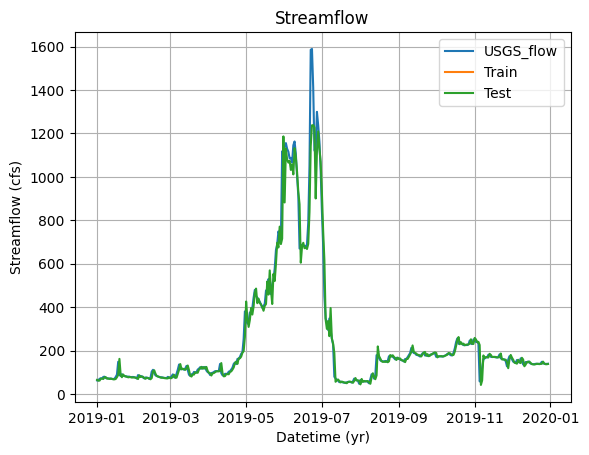

NSE 0.9595, RMSE 54.0000, MaxError 443.0000, MAPE 8.0000, KGE 0.9200 


In [16]:
#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
plot(df.loc['2019-1-1':'2019-12-30'])

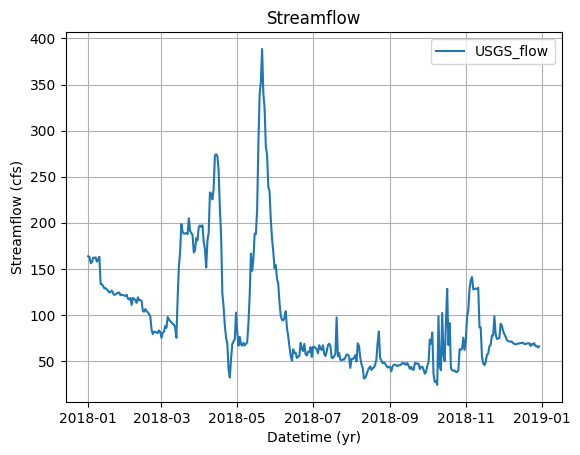

In [10]:
#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
plot(df.loc['2018-1-1':'2018-12-30'])

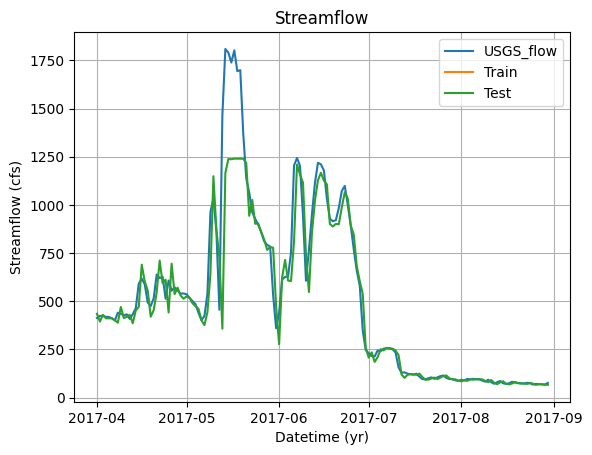

NSE 0.8203, RMSE 158.0000, MaxError 1106.0000, MAPE 10.0000, KGE 0.8000 


In [18]:
#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
plot(df.loc['2017-4-1':'2017-8-30'])

### Next Steps: items to add, after each set of feature, see how to predict streamflow without using any NWIS observations for inputs.
* NWM streamflow can we do NWM to NWIS?
* NWM forcings
* reservoir storage 
* other stream sites
* static catchment attributes